# AI演習 第10回
### ディープラーニングによる自然言語処理と時系列データ処理 (4)

[実行環境]
Colaboratoryの実行環境は更新されるので確認しておきます。

Python: 3.10.12<br>
TensorFlow: 2.14.0<br>

ランタイムのタイプは、GPUを指定するように注意してください。

In [ ]:
!python -V

In [ ]:
import tensorflow as tf

print(tf.__version__)

# ニューラル機械翻訳

* ニューラルネットワークを用いて実現する翻訳機能
* 2014年にRNNを利用した系列変換モデル(sequence-to-sequence model)が考案され、実用化された。
* 2017年にTransformerが考案され、機械翻訳の性能向上に貢献している。



# RNNを利用した系列変換モデルによる機械翻訳

* 翻訳の対象となる文章を系列データとして入力し、翻訳結果の文章を系列データとして出力する。

<img src='https://drive.google.com/uc?export=view&id=1U4jwaSgp2akrDfTv3aKvNQ4DPXLXK2GE' width='70%'>

* 系列変換モデルは、(1)入力となる系列データをエンコードし、(2)エンコードした結果をデコードして系列データを出力するため、エンコード・デコードモデルと呼ばれることがある。
* エンコードした結果を、意味ベクトルと呼ぶ。
* 意味ベクトルは固定長であるため、入力系列データの長さが大きくなると、学習が困難となる。

<img src='https://drive.google.com/uc?export=view&id=1ssHPPADGjdM7xcsvJF5dFy6yuI6iQVEo' width='70%'>

# Attention (注視機構)
* Bahdanau, Cho, Bengioらが、ニューラル機械翻訳に導入(2014年)
* 入力データに対して着目したい特徴に注視(attention)して強調する仕組み
* Sequence to sequenceモデルの性能改善に貢献
* Transformerでも重要な役割として機能


## Self-attention

* 系列データ内で着目したい情報を強調するように、元の系列データを調整する

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

In [ ]:
from gensim.models.word2vec import Word2Vec, Text8Corpus

sentences = Text8Corpus('text8')
model = Word2Vec(sentences, vector_size=100)

model.save('model.bin')

In [ ]:
model = Word2Vec.load('model.bin')

In [ ]:
text = "I book a room at the hotel."

In [ ]:
text = text.lower() # 小文字にする
text = text.replace('.', ' .') # ピリオドを分割
words = text.split(' ') # 空白を区切りにして単語を分割

In [ ]:
import numpy as np

# Self-attentionの重み行列の作成
a = np.array([])
for w1 in words:
  for w2 in words:
    try:
      score = model.wv.similarity(w1, w2)
    except:
      score = 0

    #print(w1, w2, score)
    a = np.append(a, score)

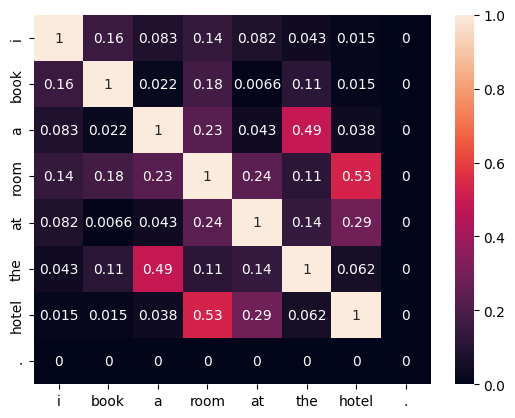

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

length = len(words)

attention_matrix = a.reshape(length, length)
#feature_names = ["0", "1", "2", "3"]
feature_names = words
# Self-attentionの重みのヒートマップを描く
sns.heatmap(attention_matrix, annot=True,
            xticklabels=feature_names,
            yticklabels=feature_names)

# グラフを表示する
plt.show()

### 確認例題 3-1
次の英文について、self-attentionの重みのヒートマップを描画してみましょう。

I cut orages with a knife.

## Self-attentionによるベクトル生成の例

まず、"I book a room at the hotel."の各単語ベクトルを足し合わせて、文書ベクトルを生成します。

In [ ]:
sentence_vec = np.zeros(model.wv["book"].size)

for i, t in enumerate(words):
  try:
    sentence_vec += model.wv[t]
  except:
    sentence_vec += 0

print ("元の文章ベクトル:", sentence_vec)

### 確認例題 3-2
確認例題3-1と同じ英文を用いて、文書ベクトルを生成してみましょう。

I cut orages with a knife.

次に"book"のSelf-attentionの重みを利用して、"I book a room at the hotel."の文書ベクトルを重み付きで生成してみます。

In [ ]:
attention_weight = attention_matrix[1] # bookのself-attentionの重み
print(attention_weight)

In [ ]:
book_attention_vec = np.zeros(model.wv["book"].size)

for i, t in enumerate(words):
  try:
    book_attention_vec += attention_weight[i] * model.wv[t]
  except:
    book_attention_vec += 0

print ("bookのSelf-attentionの重みで調整した文書ベクトル", book_attention_vec)

### 確認例題 3-3
"oranges"と"knife"の単語ベクトルについて、self-attentionによる重みを用いて調整した文書ベクトルを生成してみましょう。



# RNN機械翻訳におけるattention

* 入力系列データの各セルの出力を結合したものを意味ベクトル列とする。
* デコーダのセルの入力に対して、意味ベクトルのどの部分に着目（注視）しているかを考慮して、コンテキストベクトルを生成する。
* 入力系列データが長くなっても、精度が良い。

<img src='https://drive.google.com/uc?export=view&id=1U4zc0A0bt3-7po1QS4aa5Eum5nvUfqOa' width='70%'>

## コンテキストベクトルの計算方法

* デコーダのセルiの出力h'iに対して、意味ベクトル列の各意味ベクトル[h1, h2, …, hn]との内積を計算 → [a1, a2, …, an]
*[a1, a2, …, an]を合計が1となるように正規化 (softmaxを計算) → [a’1, a’2, …, a’n]
*意味ベクトル列の各意味ベクトルの重み付き和を計算 → コンテキストベクトルci


<img src='https://drive.google.com/uc?export=view&id=1ibCk1eq0k8LVp_Bx_Z0GEGHn2MSM-Alx' width='70%'>

## Attentionを用いたRNN系列変換モデルの構成

<img src='https://drive.google.com/uc?export=view&id=1SCu2_Ni9A4OK1E7UYW8BKx2tew0C2Igi' width='70%'>

左側のエンコーダの各出力を擬似的に算出してみます。

In [ ]:
wordvec_size = 100
hidden_size = 5

Wx = np.random.randn(wordvec_size, hidden_size)
Wo = np.random.randn(hidden_size, hidden_size)
b = np.zeros(hidden_size)

In [ ]:
def RNN_cell0(x, Wx, b):

  _o = np.dot(x, Wx) + b
  o = np.tanh(_o)

  return o

In [ ]:
def RNN_cell(x, o, Wx, Wo, b):

  o_out = np.dot(o, Wo) + np.dot(x, Wx) + b

  return o_out

In [ ]:
x1 = model.wv["i"]
x2 = model.wv["book"]
x3 = model.wv["room"]
x4 = model.wv["at"]
x5 = model.wv["the"]
x6 = model.wv["hotel"]

In [ ]:
h1 = RNN_cell0(x1, Wx, b)
h2 = RNN_cell(x2, h1, Wx, Wo, b)
h3 = RNN_cell(x3, h2, Wx, Wo, b)
h4 = RNN_cell(x4, h3, Wx, Wo, b)
h5 = RNN_cell(x5, h4, Wx, Wo, b)
h6 = RNN_cell(x6, h5, Wx, Wo, b)

右側のデコーダの最初のセルについて、擬似的に出力してみます。

In [ ]:
# "Dinner at the restaurant is my favorite."

y1 = model.wv["dinner"]
hh1 = RNN_cell0(y1, Wx, b)

"dinner"を注視するコンテキストベクトルを生成します。はじめに重みを計算します。

In [ ]:
a1 = np.dot(h1, hh1)
a2 = np.dot(h2, hh1)
a3 = np.dot(h3, hh1)
a4 = np.dot(h4, hh1)
a5 = np.dot(h5, hh1)
a6 = np.dot(h6, hh1)

重み付き和を計算することで、"dinner"に対するコンテキストベクトルを生成します。

In [ ]:
c1 = a1 * h1 + a2 * h2 + a3 * h3 + a4 * h4 + a5 * h5 + a6 * h6

### 確認例題 3-4
"restaurant"に対するコンテキストベクトルを生成してみましょう。hh2, hh3, ...などの出力には、RNN_cell(x, o, Wx, Wo, b)を用いてください。

# Transformer

* Vaswaniらが、2017年に提案
* 機械翻訳モデルとして提案されたが、広く自然言語処理や画像処理にも利用されている
* 英-独翻訳で28.4のBLEUスコア
 * BLEUスコア: 機械翻訳の精度を評価するためのスコア
* RNNのような系列構造を持たず、並列計算による高速化が可能
* BERTやGPT-nなどの深層学習モデルもとになっている
* 画像処理への適用例としては、Vision Transformer (ViT)がある。


## Transformerの構成

<img src='https://drive.google.com/uc?export=view&id=1UoTp8e9Y1NCCsr7-m7QlvQBwWRCFgfNt' width='50%'>

* Multi-head attention: query, key, valueを入力としたアテンション機構。入力データを分割して、複数の構成にしたものをMulti-headと呼んでいる。
* Masked multi-head attention: 後続の単語を参照しないようにするアテンション機構
* Positional encoding: 単語の出現位置についての埋め込み情報 (Vaswaniらは、sin関数、cos関数を用いた計算方法を提案)

## Scaled Dot-Product Attention

* Query、Key、ValueによるAttention機構
* ベクトルの大きさで正規化される（scaledされる）
* Positional Encodeingを用いて、単語の位置情報を加算する

<img src='https://drive.google.com/uc?export=view&id=1w1Wqzmli6PkzPBXR3tpc02pT5WF3LpxZ' width='50%'>

## Multi-head attention

* 入力データを分割して、複数のscaled dot-product attentionで並列処理
* 出力は、各attentionの出力(ベクトル形式)を横方向に連結(concat)

<img src='https://drive.google.com/uc?export=view&id=1cpMJTclA31kwMsLZN_Jv19cvXjp8ETEN' width='30%'>




## ポジショナルエンコーディング
* 文章中の各単語(トークン)に位置情報を与える処理

In [ ]:
import numpy as np

def positional_encoding(pos, i, dim):
  if i//2 == 0:
    return np.sin(pos/10000**(1/dim))
  else:
    return np.cos(pos/10000**((i-1)/dim))

1番目の(単語の)位置情報を100次元ベクトルで生成してみます。

In [ ]:
for i in range(0, 100):
  print(positional_encoding(1, i, 100))

### 確認例題 3-5
2番目と3番目の位置情報を100次元ベクトルで生成してみましょう。

30番目までの位置情報を配列(30個 x 100次元ベクトル)に格納します。その後可視化します。

In [ ]:
pe = np.zeros((30, 100))
for i in range(0,30):
  for j in range(0, 100):
    pe[i][j] = positional_encoding(i, j, 100)

print(pe)

[[ 0.          0.          1.         ...  1.          1.
   1.        ]
 [ 0.79073629  0.79073629  0.61215694 ...  0.99999999  0.99999999
   0.99999999]
 [ 0.96810942  0.96810942 -0.25052775 ...  0.99999996  0.99999997
   0.99999997]
 ...
 [-0.48682265 -0.48682265  0.87350083 ...  0.99999238  0.99999367
   0.99999473]
 [ 0.39269694  0.39269694  0.91966794 ...  0.99999181  0.99999319
   0.99999433]
 [ 0.96760697  0.96760697  0.2524614  ...  0.99999121  0.99999269
   0.99999392]]


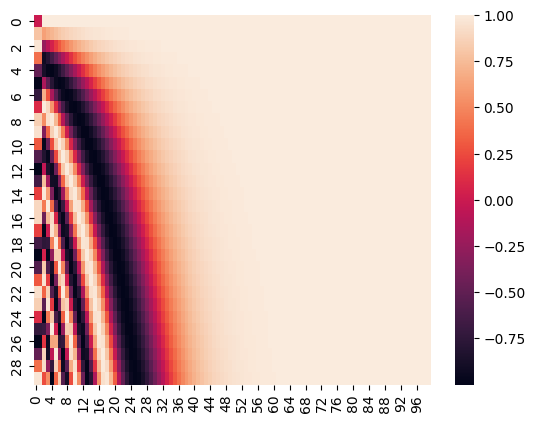

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pe)
plt.show()

"I book room at the hotel."の各単語にPositional Encodingを埋め込んでみます。

In [ ]:
xe1 = x1 + pe[0] # I
xe2 = x2 + pe[1] # book

print(xe1.shape)
print(xe2.shape)

### 確認例題 3-6
残りの単語"room"、"at"、"the"、"hotel"についても、Posisional Encodingを埋め込んだベクトルを生成してみましょう。

## Transformerエンコーダによる文章分類

Transformerエンコーダを用いて、IMDBデータセットの映画レビュー文章を分類します。

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
vocab_size = 20000 # 単語数
embed_dim = 256 # 単語埋め込み層の次元
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Trans  (None, None, 256)         543776    
 formerEncoder)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
for item in int_train_ds:
  print(item)

In [ ]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=3)

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 20s 25ms/step - loss: 0.3079 - accuracy: 0.8704
Test acc: 0.870


#### 確認例題 3-7
* Epoch数を増やして分類精度が向上するか確認しましょう。
* さらに、前回までの確認例題で確認した一次元CNN、SimpleRNN、LSTM、GRUに加えて、TransformerEncoderを含めた5つのモデルについて、分類精度を比較し、考察してみましょう。また、各モデルのパラメータ数についても比較してみましょう。

# BERT (Bidirectional Encoder Representations from Transformers)

* 双方向のエンコード表現学習を実現する深層ニューラルネットワーク

* 文脈理解の向上
 * 2019 brazil traveler to usa need a visa <br>
   ブラジルへのアメリカ人旅行者 x <br>
   アメリカへのブラジル人旅行者 o <br>

* 他のモデルへの転移学習が容易
 * 転移学習: 学習済のNNモデルを，他のNNモデルに埋め込んで利用する学習方法．少ない学習データで，認識精度の高いNNモデルが実現できる．
* ラベルが付与されていないデータセットからも学習可能（教師なし学習）

* Transformer: Attentionを用いて時系列データを処理する深層学習モデル
* Attention: 出力シーケンスの生成時に入力シーケンスのどこに注視（attention）するかを判断する仕組み

<br>
<img src='https://drive.google.com/uc?export=view&id=1J-JGdA0-yJsEbfF35goLmJSsKPCUUS-E' width='100%'>

### BERTの事前学習
* BERTは事前学習により構築したモデルを、さらに転移学習（ファインチューニング）することで様々自然言語処理タスクに適用することができる。
* 事前学習は、単語のマスクによる単語推定学習と2つの文章に対する隣接推定学習により実施される。

[例]
初期の学習による推定:<br>
{'input_text': 'i have watched this [mask] and it was awesome',<br>
 'predicted mask token': 'this',<br>
 'prediction': 'i have watched this this and it was awesome',<br>
 'probability': 0.086307295}


中盤の学習による推定:<br>
{'input_text': 'i have watched this [mask] and it was awesome',<br>
 'predicted mask token': 'movie',<br>
 'prediction': 'i have watched this movie and it was awesome',<br>
 'probability': 0.4759983}

### BERTによる文書ベクトルの出力例
* BERTを用いて、単語の分散表現を抽出することができます。文書を単語の集合とみなすと、文書の分散表現も得ることができます。
* ここでは、文書の分散表現を文書ベクトルと呼ぶことにします。
* 文書ベクトル間の類似度を計算することで、似ている文書同士を分類したり、単語ベクトルと文書ベクトルの類似度の計算による文書検索が実現できるようになります。（第6回講義のベクトル空間モデルも参照して下さい。）


<br>
<img src='https://drive.google.com/uc?export=view&id=1HgE6BVMiPAks6J88iYPtcnIk4Uk5kJ5a' width='70%'>

### BERT日本語事前学習モデルの利用
上記の文書ベクトルの出力例をコードで動かしてみます。
BERT日本語事前学習モデルを利用しています。

ここでは、BERT日本語事前学習モデルとして、京都大学で構築した 「Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers」を利用します。
このモデルは、入力テキストを形態素解析し、形態素をsubwordに分割したものを基本単位とし、日本語テキストのみ(Wikipediaを利用)で事前学習ししています。

[京都大学のウェブサイト]<br>
http://nlp.ist.i.kyoto-u.ac.jp/index.php?BERT%E6%97%A5%E6%9C%AC%E8%AA%9EPretrained%E3%83%A2%E3%83%87%E3%83%AB

#### BERT事前学習モデルなどの準備
京都大学のウェブサイトからファイルをダウンロードします。

In [ ]:
!wget -O Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip http://nlp.ist.i.kyoto-u.ac.jp/DLcounter/lime.cgi?down=http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/JapaneseBertPretrainedModel/Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip&name=Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip
!unzip Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers.zip

In [ ]:
#!pip install transformers==2.5.1
#!pip install transformers==3.4.0
!pip install transformers

#### BERT事前モデルの読み込み

In [ ]:
# -*- coding: utf-8 -*-
import torch
# from pyknp import Juman
from transformers import BertTokenizer, BertModel

text = "今日の授業は大変役に立った。"
bert_model_path = "./Japanese_L-12_H-768_A-12_E-30_BPE_WWM_transformers"

# BERT pre_trained model load
bert_model = BertModel.from_pretrained(bert_model_path)

# for Tokenizer
vocab_file_path = bert_model_path + "/vocab.txt"
bert_tokenizer = BertTokenizer(vocab_file_path, do_lower_case=False, do_basic_tokenize=False)

#### 単語のID化
形態素分解した単語リストから、トークンIDの列を取得します。以下、トークンIDの列をBERTに入力し、文書ベクトルを生成していきます。

In [ ]:
tokens = ['今日', 'の', '授業', 'は', '大変', '役', 'に', '立った', '。']

参考として、以前使用したjanomeによる形態素解解析の結果は下記のようになります。今回は、上記の単語リストを使います。

In [ ]:
!pip install janome

In [ ]:
from janome.tokenizer import Tokenizer

jt = Tokenizer()
test_tokens = []
for token in jt.tokenize(text, wakati=True):
  test_tokens.append(token)

print(test_tokens)

#### 単語ベクトルの出力
BERTモデルを利用して、トークンIDから、対応する単語ベクトルを出力します。

In [ ]:
bert_tokens = bert_tokenizer.tokenize(" ".join(["[CLS]"] + tokens + ["[SEP]"]))
print("BERT tokens: ", bert_tokens)

token_ids = bert_tokenizer.convert_tokens_to_ids(bert_tokens)
print("BERT token IDs: ", token_ids)

print("\n")
print("[Document vector]")
tokens_tensor = torch.tensor(token_ids).unsqueeze(0)
outputs = bert_model(tokens_tensor)
print(outputs[0])
print("\n (size: ", outputs[0].size(), ")")

#### 文書ベクトルの生成
単語ベクトルを足し合わせることで、文書ベクトルを生成します。

In [ ]:
import numpy as np

vectors = outputs[0].to('cpu').detach().numpy().copy()

print(vectors[0][0].shape)

doc_vectors = np.zeros(vectors[0][0].shape, dtype='float64')
print(doc_vectors.dtype)

for id in range(vectors.shape[1]):
  doc_vectors = doc_vectors + vectors[0][id]

print(doc_vectors)

### 確認例題 3-8

3個の文章を用意し、文書ベクトルを生成してみましょう。




### 確認例題 3-9
さらに、各文章間の類似度をベクトル空間モデルを適用して計算してみましょう。（やり方は確認例題1-10などを復習してみてください。）

# 参考文献
* Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova, BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, https://arxiv.org/abs/1810.04805v1, 2018.
* Keras公式サイト, https://keras.io/examples/